# Fine Tuning ChemBERTa for Toxicity prediction on ClinTox dataset

## **Install and import required libraries**

In [1]:
!pip install transformers
!pip install evaluate
!pip install accelerate -U
!pip install rdkit-pypi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 15.3 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 4.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-ma

In [76]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw.MolDrawing import DrawingOptions
from IPython.display import SVG
from IPython.display import HTML

import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from transformers import AutoConfig, AutoTokenizer, AutoModel, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import evaluate

In [3]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/My Drive/ChemBERTa')
!pwd

Mounted at /content/drive
/content/drive/My Drive/ChemBERTa


## **Read Data**

In [4]:
data = pd.read_csv('clintox.csv')
print(data.shape)
data.head()


(1484, 3)


,smiles,FDA_APPROVED,CT_TOX
0,*C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC,1,0
1,[C@@H]1([C@@H]([C@@H]([C@H]([C@@H]([C@@H]1Cl)C...,1,0
2,[C@H]([C@@H]([C@@H](C(=O)[O-])O)O)([C@H](C(=O)...,1,0
3,[H]/[NH+]=C(/C1=CC(=O)/C(=C\C=c2ccc(=C([NH3+])...,1,0
4,[H]/[NH+]=C(\N)/c1ccc(cc1)OCCCCCOc2ccc(cc2)/C(...,1,0


In [5]:
data.rename(columns = {'smiles': 'Smiles', 'CT_TOX': 'label'}, inplace=True)
print(data['label'].value_counts())

label
0    1372
1     112
Name: count, dtype: int64


<Axes: xlabel='label', ylabel='count'>

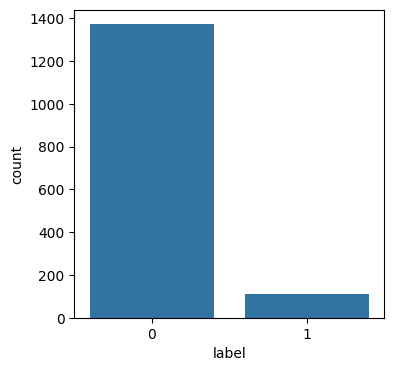

In [6]:
# Label distribution
plt.figure(figsize=(4,4))
sns.countplot(data, x = 'label')

In [7]:
# Smiles length distribution
max_length_smiles = max([len(x) for x in data['Smiles']])
max_length_smiles

339

In [8]:
data['Smiles_Length'] = data['Smiles'].apply(lambda x : len(x))
data.head()

,Smiles,FDA_APPROVED,label,Smiles_Length
0,*C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC,1,0,39
1,[C@@H]1([C@@H]([C@@H]([C@H]([C@@H]([C@@H]1Cl)C...,1,0,59
2,[C@H]([C@@H]([C@@H](C(=O)[O-])O)O)([C@H](C(=O)...,1,0,54
3,[H]/[NH+]=C(/C1=CC(=O)/C(=C\C=c2ccc(=C([NH3+])...,1,0,60
4,[H]/[NH+]=C(\N)/c1ccc(cc1)OCCCCCOc2ccc(cc2)/C(...,1,0,59


<Axes: xlabel='Smiles_Length', ylabel='Count'>

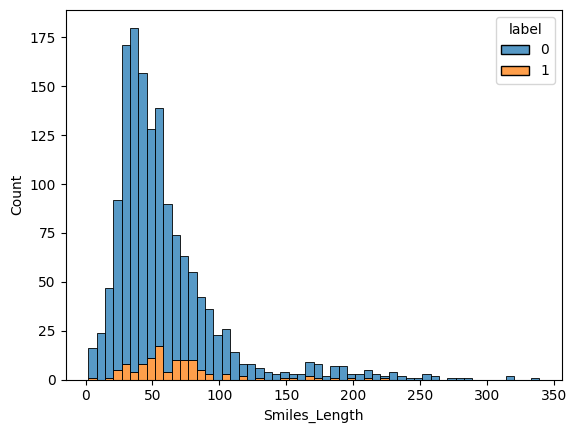

In [9]:
sns.histplot(data, x = 'Smiles_Length', hue = 'label', multiple = 'stack')

## **Train, Validation and Test Split**

In [10]:
train, test = train_test_split(data, test_size = 0.1, random_state=42, stratify = data['label'])
train, val = train_test_split(train, test_size = 0.1, random_state=42, stratify = train['label'])
print('Train :', train.shape)
print('Val :', val.shape)
print('Test :', test.shape)

Train : (1201, 4)
Val : (134, 4)
Test : (149, 4)


## **Load Pretrained Model and Tokenizer**

In [11]:
model_name = "DeepChem/ChemBERTa-77M-MTR"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/17.7k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/6.96k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.26k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/420 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.0M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## **Create PyTorch Dataset**

In [12]:
class ClinTox(torch.utils.data.Dataset):

  def __init__(self, data, tokenizer, max_length):
    self.data = data
    self.tokenizer = tokenizer
    self.max_length = max_length

  def __len__(self):
    return (len(self.data))

  def __getitem__(self, index):
    smiles = self.data.iloc[index]['Smiles']
    label = self.data.iloc[index]['label']
    smiles_encoded = self.tokenizer(smiles, padding = 'max_length', truncation = True, max_length=self.max_length, return_tensors ='pt')
    input_ids = smiles_encoded['input_ids'].squeeze(0)
    attention_mask = smiles_encoded['attention_mask'].squeeze(0)
    label = torch.tensor(label).unsqueeze(0)
    input_dict = {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': label}
    return input_dict


In [13]:
train_data = ClinTox(train, tokenizer, 300)
val_data = ClinTox(val, tokenizer, 300)
test_data = ClinTox(test, tokenizer, 300)

In [14]:
# check one sample from train data
train_data[0]

{'input_ids': tensor([12, 16, 20, 16, 16, 16, 17, 16, 17, 16, 20, 18, 23, 26, 18, 23, 13,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0

## **Training Arguments**

In [15]:
training_args = TrainingArguments(
                output_dir = './output',
                logging_dir = './output/logs',
                logging_strategy = 'epoch',
                logging_steps = 100,
                num_train_epochs = 15,
                per_device_train_batch_size = 32,
                per_device_eval_batch_size = 32,
                learning_rate = 8e-5,
               # weight_decay = 0.0005,
                seed = 42,
                save_strategy = 'epoch',
                save_steps = 100,
                evaluation_strategy = 'epoch',
                eval_steps = 100,
                load_best_model_at_end = True)

## **Evalutaion Metrics**

In [16]:
def compute_metrics(eval_predictions):
  metric = evaluate.load('accuracy')
  logits, labels = eval_predictions
  preds = np.argmax(logits, axis=1)
  return metric.compute(predictions=preds, references=labels)

## **Train Model**

In [17]:
trainer = Trainer(
          model = model,
          args = training_args,
          train_dataset = train_data,
          eval_dataset = val_data,
          compute_metrics = compute_metrics)
         # callbacks = [EarlyStoppingCallback(early_stopping_patience = 1)])

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.482100,0.204470,0.925373
2,0.167800,0.084502,0.970149
3,0.090800,0.035253,0.992537
4,0.056600,0.023446,0.992537
5,0.044900,0.020501,1.000000
6,0.036300,0.017725,1.000000
7,0.031700,0.014618,1.000000
8,0.029900,0.023447,0.985075
9,0.026800,0.024158,0.985075
10,0.025300,0.024424,0.985075


TrainOutput(global_step=570, training_loss=0.07340122252179865, metrics={'train_runtime': 95.3166, 'train_samples_per_second': 189.002, 'train_steps_per_second': 5.98, 'total_flos': 97270169382000.0, 'train_loss': 0.07340122252179865, 'epoch': 15.0})

## **Plot loss and accuracy curves**

<ipython-input-18-0f6b5e0d8ad0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_loss.dropna(inplace = True)
<ipython-input-18-0f6b5e0d8ad0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_loss.dropna(inplace = True)
<ipython-input-18-0f6b5e0d8ad0>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_accuracy.dropna(inplace = True)


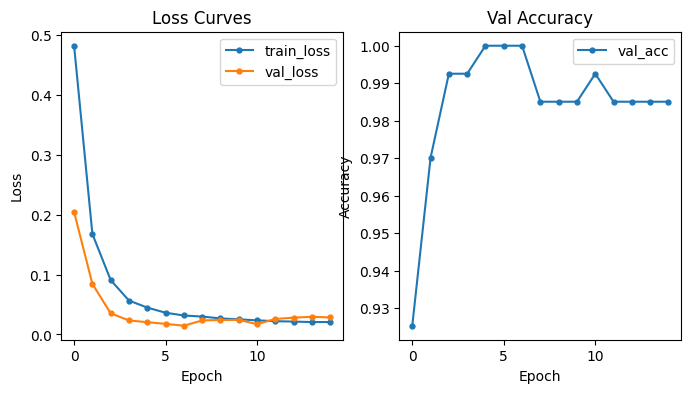

In [18]:
history = pd.DataFrame(trainer.state.log_history)

train_loss = history[['loss']]
train_loss.dropna(inplace = True)
train_loss.reset_index(drop = True, inplace = True)

val_loss = history[['eval_loss']]
val_loss.dropna(inplace = True)
val_loss.reset_index(drop = True, inplace = True)

val_accuracy = history[['eval_accuracy']]
val_accuracy.dropna(inplace = True)
val_accuracy.reset_index(drop = True, inplace = True)

loss_acc = pd.concat([train_loss, val_loss, val_accuracy], axis = 1)

fig, ax = plt.subplots(1,2,figsize=(8,4))

ax[0].plot(loss_acc['loss'], label='train_loss', marker='.', markersize=7)
ax[0].plot(loss_acc['eval_loss'], label='val_loss', marker='.', markersize=7)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss Curves')
ax[0].legend(loc='best')

ax[1].plot(loss_acc['eval_accuracy'], label='val_acc', marker='.', markersize=7)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Val Accuracy')
ax[1].legend(loc='best')


## **Test Dataset Performance**

In [19]:
trainer.evaluate(test_data)

{'eval_loss': 0.045119207352399826,
 'eval_accuracy': 0.9865771812080537,
 'eval_runtime': 1.0639,
 'eval_samples_per_second': 140.048,
 'eval_steps_per_second': 4.7,
 'epoch': 15.0}

In [25]:
# Get predicted logits
test_predict = trainer.predict(test_data)
test_logits = test_predict[0]
test_logits[:5]

array([[ 4.5557146, -4.7731524],
       [ 1.07147  , -1.008633 ],
       [ 1.5677133, -1.6244681],
       [ 4.676931 , -4.8896422],
       [ 5.058773 , -5.32277  ]], dtype=float32)

In [28]:
# Convert logits to probabilities
test_logits_tensor = torch.from_numpy(test_logits)
test_probabilities = torch.softmax(test_logits_tensor, dim=1)
test_probabilities[:5]

tensor([[9.9991e-01, 8.8815e-05],
        [8.8895e-01, 1.1105e-01],
        [9.6054e-01, 3.9461e-02],
        [9.9993e-01, 7.0026e-05],
        [9.9997e-01, 3.0998e-05]])

In [50]:
# Get predicted labels
predicted_labels = np.argmax(test_probabilities, axis=1)
predicted_labels[:5]

tensor([0, 0, 0, 0, 0])

In [51]:
# Get true labels
true_labels = test_predict[1]
true_labels = np.squeeze(true_labels)
true_labels = torch.tensor(true_labels)
true_labels[:5]

tensor([0, 0, 0, 0, 0])

### **Classification Report**

In [53]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       138
           1       0.85      1.00      0.92        11

    accuracy                           0.99       149
   macro avg       0.92      0.99      0.95       149
weighted avg       0.99      0.99      0.99       149



### **Confusion Matrix**

In [54]:
cm = confusion_matrix(true_labels, predicted_labels)
cm

array([[136,   2],
       [  0,  11]])

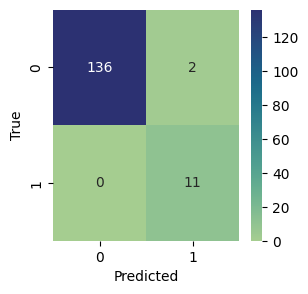

In [56]:
df_cm = pd.DataFrame(cm, index = [0, 1], columns = [0, 1])

plt.figure(figsize=(3,3))
sns.heatmap(df_cm, annot=True, cmap='crest', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## **Save tokenizer and model**

In [57]:
tokenizer.save_pretrained('./output')

('./output/tokenizer_config.json',
 './output/special_tokens_map.json',
 './output/vocab.json',
 './output/merges.txt',
 './output/added_tokens.json',
 './output/tokenizer.json')

In [58]:
trainer.save_model('./output')

## **Visualize Atttention Scores**

In [59]:
# Load saved tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('./output')
model = AutoModelForSequenceClassification.from_pretrained('./output')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [60]:
# Create a function to get attention scores for a smiles string

def get_attention_scores (smiles, tokenizer, model):
  smiles_encoded = tokenizer(smiles, return_tensors='pt')
  output = model.base_model(**smiles_encoded, output_attentions=True)
  attentions = output.attentions
  return attentions

In [77]:
# Create a function to visualize attention scores for a smiles string

def visualize_attentions(smiles, tokenizer, attentions, layer, head):
  mol = Chem.MolFromSmiles(smiles)
  smiles_encoded = tokenizer(smiles, return_tensors='pt')
  tokens = tokenizer.convert_ids_to_tokens(smiles_encoded['input_ids'][0].tolist())
  # Create a token to atom map
  special_tokens = ['<s>', '</s>', '[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']
  token_idx2atom_idx = {}
  atomidx = 0
  for i, token in enumerate(tokens):
    if token.isalpha() and token not in special_tokens:
      token_idx2atom_idx[i] = atomidx
      atomidx += 1

  # Get atom_attention_scores
  attention_scores = attentions[layer][0][head].detach().numpy()
  atom_attention_scores = np.zeros(mol.GetNumAtoms())
  for token_idx, atom_idx in token_idx2atom_idx.items():
    atom_attention_scores[atom_idx] = attention_scores[token_idx].sum()

  # Normalize atom_attention_scores
  atom_attention_scores = (atom_attention_scores - atom_attention_scores.min()) / (atom_attention_scores.max() - atom_attention_scores.min())

  # Project scores onto molecular structure
  for atom_idx, attention_score in enumerate(atom_attention_scores):
    mol.GetAtomWithIdx(atom_idx).SetProp('atomNote', f"{attention_score:.3f}")

  drawer = rdMolDraw2D.MolDraw2DSVG(300, 300)
  drawer.SetFontSize(12)

  rdMolDraw2D.PrepareAndDrawMolecule(drawer, mol, highlightAtoms=range(mol.GetNumAtoms()), highlightBonds=[])
  drawer.FinishDrawing()
  return SVG(drawer.GetDrawingText())



In [80]:
# Visualize attention on a smiles string from test data
smiles = 'CCC1(CC(=O)NC1=O)C'

# Get attention scores
attentions = get_attention_scores(smiles, tokenizer, model)

In [79]:
# Display molecular structures with the attention scores for the third layer and all (12) attention heads

table = "<table>"
for layer in range(2,3):

    for head in range(12):
        if head % 4 == 0:
            table += "<tr>"

        svg = visualize_attentions(smiles, tokenizer, attentions, layer, head)
        table += f"<td><h3>Layer {layer}, Head {head}</h3>{svg.data}</td>"

        if (head + 1) % 4 == 0:
            table += "</tr>"
table += "</table>"

display(HTML(table))